## Problem 1

In this problem, you will work on implementing and comparing several transfer learning estimators.

### 1.1

**Note on randomness:** `np.random.default_rng(seed)` creates a new RNG object (modern API). We store it in `rng` and use `rng.normal(...)` to draw samples. This is the recommended replacement for the legacy `np.random.randn(...)`, which uses a global RNG state.


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def generate_two_tasks(n1=200, n2=100, p=100, noise_std=0.1, delta=0.01, seed=42):
    """
    Generate two synthetic linear regression tasks.

    Each task has covariates drawn from N(0, I_p) and labels
    generated from a linear model with Gaussian noise.

    Returns
    -------
    X1, y1, X2, y2, beta1, beta2
    """
    rng = np.random.default_rng(seed)
    
    # Isotropic Gaussian for features and coefficients: N(feature_mean, feature_std^2)
    feature_mean = 0.0
    feature_std = 1.0

    # Generate beta2 with controlled shift where ||beta1 - beta2||_2 ~= delta.
    # beta2 ~ N(0, I_p), beta2 = beta1 + delta * u with ||u||_2 = 1.
    beta1 = rng.normal(feature_mean, feature_std, size=p)

    u = rng.normal(0.0, 1.0, size=p)
    u = u / np.linalg.norm(u) # normalize u to have unit norm
    beta2 = beta1 + delta * u

    # X: covariates/features for each task
    # Generate feature vectors from isotropic Gaussian N(0, I_p)
    X1 = rng.normal(feature_mean, feature_std, size=(n1, p))
    X2 = rng.normal(feature_mean, feature_std, size=(n2, p))

    # Generate labels with Gaussian noise (mean 0, std = noise_std)
    # y = X @ beta + noise, where noise ~ N(0, noise_std^2)
    y1 = X1 @ beta1 + rng.normal(0.0, noise_std, size=n1)
    y2 = X2 @ beta2 + rng.normal(0.0, noise_std, size=n2)

    return X1, y1, X2, y2, beta1, beta2

# Quick test
X1, y1, X2, y2, beta1, beta2 = generate_two_tasks(delta=0.5)
actual_shift = np.linalg.norm(beta1 - beta2)
print(f"Expected shift: 0.5, Actual shift: {actual_shift:.6f}")


Expected shift: 0.5, Actual shift: 0.500000


### 1.2

In [3]:
def fit_ols(X, y):
    """Ordinary least squares via least squares solver."""
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    return beta

In [4]:
def fit_hps(X1, y1, X2, y2):
    """Hard parameter sharing: fit one beta on pooled data."""
    X = np.vstack([X1, X2])
    y = np.concatenate([y1, y2])
    return fit_ols(X, y)

    # """ (mathematically equivalent to eq 10 from lecture notes)."""
    # n1, n2 = len(y1), len(y2)
    # weight = np.sqrt(np.concatenate([
    #     np.ones(n1) / (n1 + n2),
    #     np.ones(n2) / (n1 + n2)
    # ]))
    # X = np.vstack([X1, X2]) * weight[:, None]
    # y = np.concatenate([y1, y2]) * weight
    # return fit_ols(X, y)

In [5]:
def fit_ols(X, y, alpha=0.01):
    """OLS with mild ridge regularization for numerical stability."""
    n, p = X.shape
    # Solve: (X^T X + alpha*I) beta = X^T y
    XtX = X.T @ X
    Xty = X.T @ y
    beta, *_ = np.linalg.lstsq(XtX + alpha * np.eye(p), Xty, rcond=None)
    return beta

def fit_hps(X1, y1, X2, y2, alpha=0.01):
    """Hard parameter sharing with regularization."""
    X = np.vstack([X1, X2])
    y = np.concatenate([y1, y2])
    return fit_ols(X, y, alpha)

In [6]:
def compute_test_loss(X_test, y_test, beta_hat):
    """Compute MSE on test data given X, y, and fitted beta."""
    y_pred = X_test @ beta_hat
    return np.mean((y_test - y_pred) ** 2)

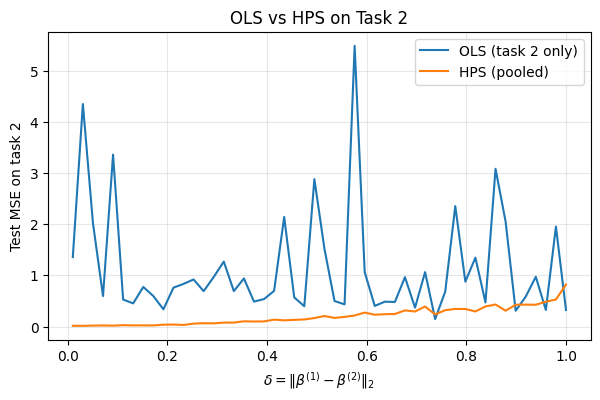

In [7]:
# Fixed setup
n1 = 200
n2 = 100
p = 100
noise_std = 0.1
seed = 42

# Vary delta from 0.01 to 1.00
num_points = 50
deltas = np.linspace(0.01, 1.00, num_points)

ols_losses = []
hps_losses = []


# Test set for task 2 (a separate holdout set)
rng_test = np.random.default_rng(seed + 999)
X2_test = rng_test.normal(0.0, 1.0, size=(100, p))

for i, delta in enumerate(deltas):
    X1, y1, X2, y2, beta1, beta2 = generate_two_tasks(
        n1=n1, n2=n2, p=p, noise_std=noise_std, delta=delta, seed=seed+i
    )

    # OLS on task 2 only
    beta_ols = fit_ols(X2, y2)

    # HPS: pooled fit on tasks 1 and 2
    beta_hps = fit_hps(X1, y1, X2, y2)

    # Task 2 test labels from true beta2
    y2_test = X2_test @ beta2 + rng_test.normal(0.0, noise_std, size=X2_test.shape[0])

    ols_losses.append(compute_test_loss(X2_test, y2_test, beta_ols))
    hps_losses.append(compute_test_loss(X2_test, y2_test, beta_hps))

# Plot test losses on task 2
plt.figure(figsize=(7, 4))
plt.plot(deltas, ols_losses, label="OLS (task 2 only)")
plt.plot(deltas, hps_losses, label="HPS (pooled)")
plt.xlabel(r"$\delta = \|\beta^{(1)} - \beta^{(2)}\|_2$")
plt.ylabel("Test MSE on task 2")
plt.title("OLS vs HPS on Task 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 1.3 Soft parameter sharing (SPS)

We add a penalty on the difference between task parameters: $\lambda \|\beta^{(1)} - \beta^{(2)}\|_2^2$.


In [8]:
def fit_sps(X1, y1, X2, y2, lam, alpha=0.01):
    """Soft parameter sharing with penalty lam * ||beta1 - beta2||^2."""
    n1, p = X1.shape
    n2, p2 = X2.shape
    if p != p2:
        raise ValueError("X1 and X2 must have the same number of features")

    XtX1 = X1.T @ X1 + alpha * np.eye(p)
    XtX2 = X2.T @ X2 + alpha * np.eye(p)
    Xty1 = X1.T @ y1
    Xty2 = X2.T @ y2

    # Solve the block system for [beta1; beta2]
    A = np.block([
        [XtX1 + lam * np.eye(p), -lam * np.eye(p)],
        [-lam * np.eye(p), XtX2 + lam * np.eye(p)],
    ])
    b = np.concatenate([Xty1, Xty2])
    beta = np.linalg.solve(A, b)

    beta1_hat = beta[:p]
    beta2_hat = beta[p:]
    return beta1_hat, beta2_hat


In [9]:
# Tune lambda for SPS on a fixed delta
n1 = 200
n2 = 100
p = 100
noise_std = 0.1
seed = 42

delta_sps = 0.5
X1, y1, X2, y2, beta1, beta2 = generate_two_tasks(
    n1=n1, n2=n2, p=p, noise_std=noise_std, delta=delta_sps, seed=seed
)

rng_test = np.random.default_rng(seed + 999)
X2_test = rng_test.normal(0.0, 1.0, size=(100, p))
y2_test = X2_test @ beta2 + rng_test.normal(0.0, noise_std, size=X2_test.shape[0])

lambdas = np.logspace(-3, 2, 20)
best_lambda = None
best_loss = np.inf

for lam in lambdas:
    _, beta2_sps = fit_sps(X1, y1, X2, y2, lam=lam)
    loss = compute_test_loss(X2_test, y2_test, beta2_sps)
    if loss < best_loss:
        best_loss = loss
        best_lambda = lam

print(f"Best lambda: {best_lambda:.4g}")
print(f"Best SPS test loss (task 2): {best_loss:.6f}")


Best lambda: 4.833
Best SPS test loss (task 2): 0.059015


### 1.4 HPS vs SPS across $\delta$

We use the best $\lambda$ from above and compare test losses on task 2.


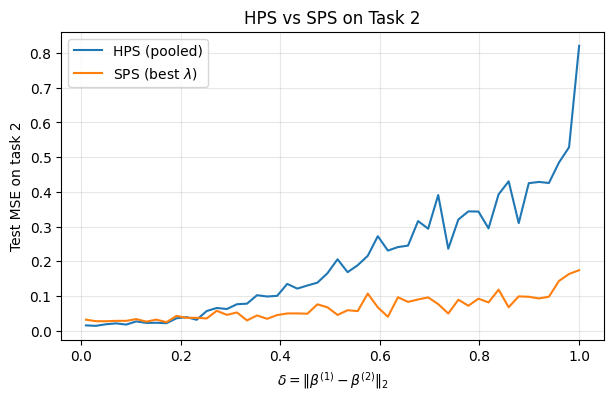

In [10]:
# Vary delta and compare HPS vs SPS on task 2
num_points = 50
deltas = np.linspace(0.01, 1.00, num_points)

hps_losses = []
sps_losses = []

rng_test = np.random.default_rng(seed + 999)
X2_test = rng_test.normal(0.0, 1.0, size=(100, p))

for i, delta in enumerate(deltas):
    X1, y1, X2, y2, beta1, beta2 = generate_two_tasks(
        n1=n1, n2=n2, p=p, noise_std=noise_std, delta=delta, seed=seed + i
    )

    beta_hps = fit_hps(X1, y1, X2, y2)
    _, beta2_sps = fit_sps(X1, y1, X2, y2, lam=best_lambda)

    y2_test = X2_test @ beta2 + rng_test.normal(0.0, noise_std, size=X2_test.shape[0])

    hps_losses.append(compute_test_loss(X2_test, y2_test, beta_hps))
    sps_losses.append(compute_test_loss(X2_test, y2_test, beta2_sps))

plt.figure(figsize=(7, 4))
plt.plot(deltas, hps_losses, label="HPS (pooled)")
plt.plot(deltas, sps_losses, label="SPS (best $\\lambda$)")
plt.xlabel(r"$\delta = \|\beta^{(1)} - \beta^{(2)}\|_2$")
plt.ylabel("Test MSE on task 2")
plt.title("HPS vs SPS on Task 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## To-Do (OH): figure out random spikes cause for OLS


### Problem 2

**Proofs.** A zero-mean random variable $X$ is sub-Gaussian with parameter $\sigma_x^2$ if
$\mathbb{E}[e^{tX}] \le \exp(\sigma_x^2 t^2/2)$ for all $t\in\mathbb{R}$.

1) For $c>0$,
$\mathbb{E}[e^{t(cX)}] = \mathbb{E}[e^{(ct)X}] \le \exp(\sigma_x^2 (ct)^2/2)$, so $cX$ is sub-Gaussian with parameter $c^2\sigma_x^2$.

2) If $X$ and $Y$ are independent sub-Gaussians with parameters $\sigma_x^2$ and $\sigma_y^2$, then
$\mathbb{E}[e^{t(X+Y)}] = \mathbb{E}[e^{tX}]\,\mathbb{E}[e^{tY}] \le \exp((\sigma_x^2+\sigma_y^2)t^2/2)$,
so $X+Y$ is sub-Gaussian with parameter $\sigma_x^2+\sigma_y^2$.


In [25]:
# Simulation utilities
rng = np.random.default_rng(42)

def simulate_gaussian_hist(mean, var, n_samples=1000, bins=50, ax=None, label=None):
    """Draw samples from N(mean, var) and plot its histogram."""
    if ax is None:
        ax = plt.gca()
    samples = rng.normal(mean, np.sqrt(var), size=n_samples)
    ax.hist(samples, bins=bins, alpha=0.5, density=True, label=label)
    return samples

# Parameters (defined as VARIANCES for sub-Gaussian)
sigma_squared_x = 4.0  # variance of X
sigma_squared_y = 9.0  # variance of Y
c = 3.0
n_samples = 1000

# Generate sub-Gaussian random variables (Gaussian for simplicity)
X = rng.normal(0.0, np.sqrt(sigma_squared_x), size=n_samples)
Y = rng.normal(0.0, np.sqrt(sigma_squared_y), size=n_samples)

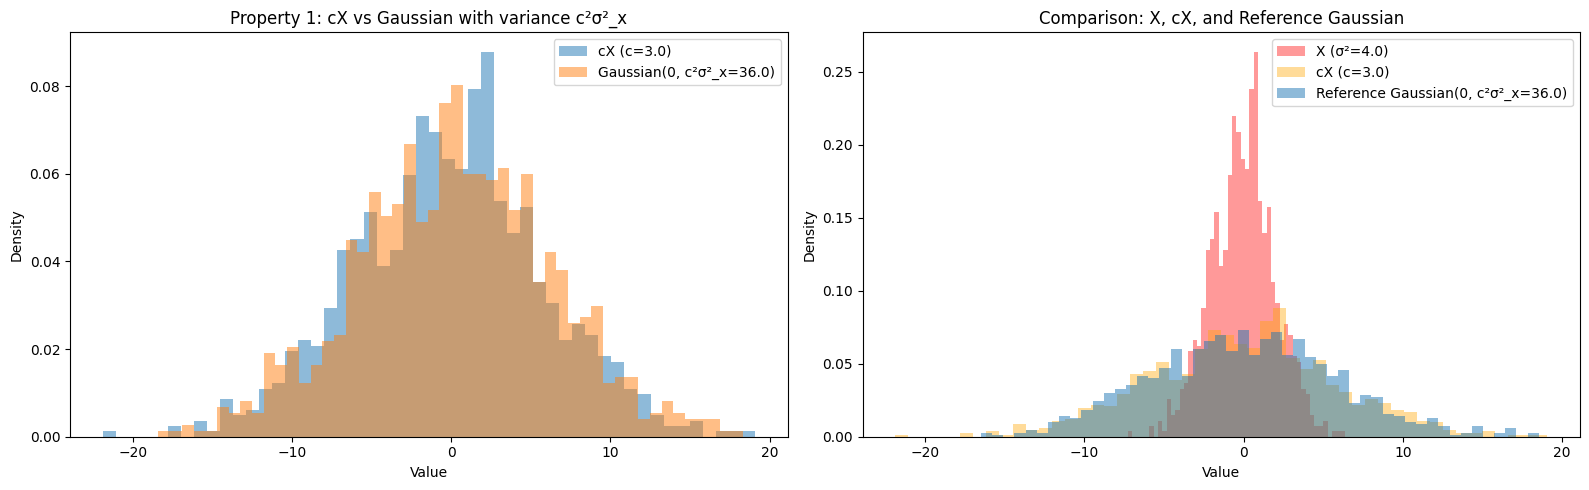

Variance of X: 3.9103, Expected: 4.0000
Variance of cX: 35.1926, Expected: 36.0000


In [26]:
# Test Property 1: cX
cX = c * X
expected_variance_cX = c**2 * sigma_squared_x

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Subplot 1: Just cX vs reference (without original X)
ax1.hist(cX, bins=50, alpha=0.5, label=f'cX (c={c})', density=True)
simulate_gaussian_hist(
    0.0,
    expected_variance_cX,
    n_samples=n_samples,
    bins=50,
    ax=ax1,
    label=f"Gaussian(0, c²σ²_x={expected_variance_cX:.1f})",
)
ax1.legend()
ax1.set_title('Property 1: cX vs Gaussian with variance c²σ²_x')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Subplot 2: Show X, cX, and reference for comparison
ax2.hist(X, bins=50, alpha=0.4, label=f'X (σ²={sigma_squared_x:.1f})', density=True, color='red')
ax2.hist(cX, bins=50, alpha=0.4, label=f'cX (c={c})', density=True, color='orange')
simulate_gaussian_hist(
    0.0,
    expected_variance_cX,
    n_samples=n_samples,
    bins=50,
    ax=ax2,
    label=f"Reference Gaussian(0, c²σ²_x={expected_variance_cX:.1f})",
)
ax2.legend()
ax2.set_title('Comparison: X, cX, and Reference Gaussian')
ax2.set_xlabel('Value')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Verify empirical variances
print(f"Variance of X: {np.var(X):.4f}, Expected: {sigma_squared_x:.4f}")
print(f"Variance of cX: {np.var(cX):.4f}, Expected: {expected_variance_cX:.4f}")

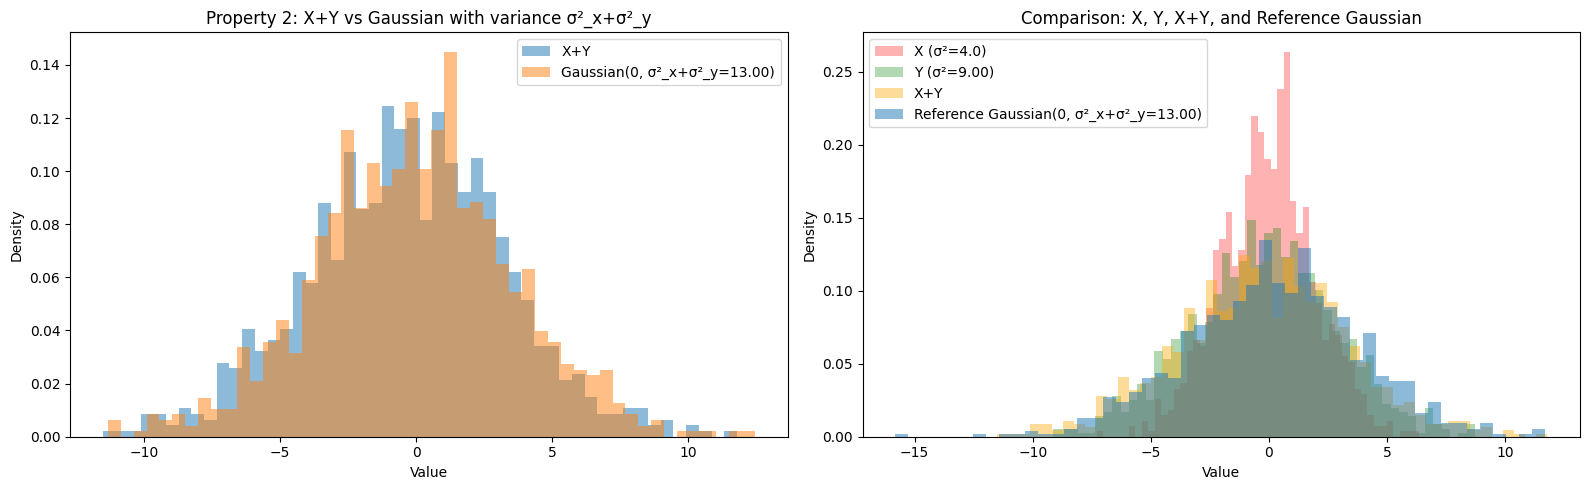

Variance of X: 3.9103, Expected: 4.0000
Variance of Y: 9.2544, Expected: 9.0000
Variance of X+Y: 13.0697, Expected: 13.0000


In [27]:
# Test Property 2: X+Y
XplusY = X + Y
expected_variance_sum = sigma_squared_x + sigma_squared_y

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Subplot 1: Just X+Y vs reference (without individual X and Y)
ax1.hist(XplusY, bins=50, alpha=0.5, label='X+Y', density=True)
simulate_gaussian_hist(
    0.0,
    expected_variance_sum,
    n_samples=n_samples,
    bins=50,
    ax=ax1,
    label=f"Gaussian(0, σ²_x+σ²_y={expected_variance_sum:.2f})",
)
ax1.legend()
ax1.set_title('Property 2: X+Y vs Gaussian with variance σ²_x+σ²_y')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Subplot 2: Show X, Y, X+Y, and reference for comparison
ax2.hist(X, bins=50, alpha=0.3, label=f'X (σ²={sigma_squared_x:.1f})', density=True, color='red')
ax2.hist(Y, bins=50, alpha=0.3, label=f'Y (σ²={sigma_squared_y:.2f})', density=True, color='green')
ax2.hist(XplusY, bins=50, alpha=0.4, label='X+Y', density=True, color='orange')
simulate_gaussian_hist(
    0.0,
    expected_variance_sum,
    n_samples=n_samples,
    bins=50,
    ax=ax2,
    label=f"Reference Gaussian(0, σ²_x+σ²_y={expected_variance_sum:.2f})",
)
ax2.legend()
ax2.set_title('Comparison: X, Y, X+Y, and Reference Gaussian')
ax2.set_xlabel('Value')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Verify empirical variances
print(f"Variance of X: {np.var(X):.4f}, Expected: {sigma_squared_x:.4f}")
print(f"Variance of Y: {np.var(Y):.4f}, Expected: {sigma_squared_y:.4f}")
print(f"Variance of X+Y: {np.var(XplusY):.4f}, Expected: {expected_variance_sum:.4f}")
